##**Import** **required Libraries**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

In [7]:
!apt-get install git-lfs -y
!git lfs install
!git clone https://github.com/MounikaMudavath/Social-Media-Sentiment-Analysis.git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Updated git hooks.
Git LFS initialized.
Cloning into 'Social-Media-Sentiment-Analysis'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 63 (delta 15), reused 25 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 7.41 MiB | 14.90 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [8]:
%cd Social-Media-Sentiment-Analysis

/content/Social-Media-Sentiment-Analysis/Social-Media-Sentiment-Analysis/Social-Media-Sentiment-Analysis


In [9]:
!git lfs pull


In [11]:
import pandas as pd

encode = "ISO-8859-1"
columns = ["sentiment", "id", "date", "query", "user", "text"]

dataset = pd.read_csv("training.1600000.processed.noemoticon.csv",
                      encoding=encode, names=columns, low_memory=False)

dataset = dataset[['sentiment','text']]

print(dataset.head())


   sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....


**(1 = Positive, 0 = Negative)**

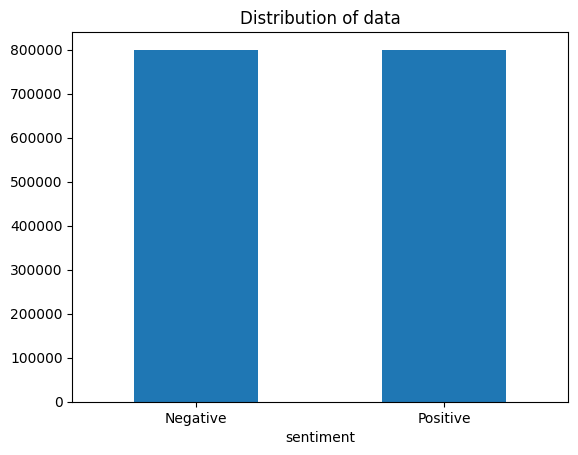

In [14]:
# plotting
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [15]:
dataset

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


## **Defining emojis and stopwords list**

In [16]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

## **Preprocessing Data**

In [17]:
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer

def preprocess(textdata):
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    wordStem = PorterStemmer()

    # Defining regex patterns.
    urlPattern        = r'https?://\S+|www\.\S+'
    userPattern       = r'@[^\s]+'
    alphaPattern      = r'[^a-zA-Z]'
    sequencePattern   = r'(.)\1\1+'
    seqReplacePattern = r'\1\1'

    processedText = []

    for text in textdata:
        text = text.lower()
        text = re.sub(urlPattern, '', text)
        text = re.sub(userPattern, '', text)
        text = re.sub(alphaPattern, ' ', text)
        text = re.sub(sequencePattern, seqReplacePattern, text)

        text = ' '.join([wordLemm.lemmatize(wordStem.stem(word)) for word in text.split()])
        processedText.append(text)

    return processedText


In [20]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')   # (optional but helps with lemmatization for more languages)

lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("running"))   # example

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


running


In [27]:
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def remove_stopwords(texts):
    cleaned = []
    for sentence in texts:                      # loop over each tweet
        words = [w for w in sentence.split() if w not in stop_words]
        cleaned.append(" ".join(words))         # join back into sentence
    return cleaned

In [31]:
import re

def preprocess_fast(textdata):
    urlPattern        = r'https?://\S+|www\.\S+'
    userPattern       = r'@[^\s]+'
    alphaPattern      = r'[^a-zA-Z]'
    sequencePattern   = r'(.)\1\1+'
    seqReplacePattern = r'\1\1'

    processedText = []
    for text in textdata:
        text = text.lower()
        text = re.sub(urlPattern, '', text)            # remove URLs
        text = re.sub(userPattern, '', text)           # remove mentions
        text = re.sub(alphaPattern, ' ', text)         # keep only letters
        text = re.sub(sequencePattern, seqReplacePattern, text)  # reduce repeated chars
        processedText.append(text.strip())
    return processedText


In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def remove_stopwords(texts):
    cleaned = []
    for sentence in texts:                      # loop over each tweet
        words = [w for w in sentence.split() if w not in stop_words]
        cleaned.append(" ".join(words))         # join back
    return cleaned


In [33]:
# Preprocess first
dataset["clean_text"] = preprocess_fast(dataset["text"])

# Then remove stopwords
dataset["clean_text"] = remove_stopwords(dataset["clean_text"])

# Preview
print(dataset[["text", "clean_text"]].head())


                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                          clean_text  
0        aww bummer shoulda got david carr third day  
1  upset update facebook texting might cry result...  
2  dived many times ball managed save rest go bounds  
3                   whole body feels itchy like fire  
4                                   behaving mad see  


## **Splitting data as test and train dataset**

In [36]:
X = dataset["clean_text"]
y = dataset["sentiment"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)


In [37]:
print(len(X_train), len(X_test))

1280000 320000


## **Vectorization**

## **Tranforming the dataset into matrix of TF-IDF Features**

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectoriser = TfidfVectorizer(max_features=5000)
vectoriser.fit(X_train)

print("Vectoriser fitted.")
print("No. of feature words: ", len(vectoriser.get_feature_names_out()))


Vectoriser fitted.
No. of feature words:  5000


In [40]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


##**Creating** **`Model`**

In [41]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### <a name="p8-3">Logistic Regression Model</a>

              precision    recall  f1-score   support

           0       0.78      0.75      0.77    159815
           4       0.76      0.79      0.78    160185

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



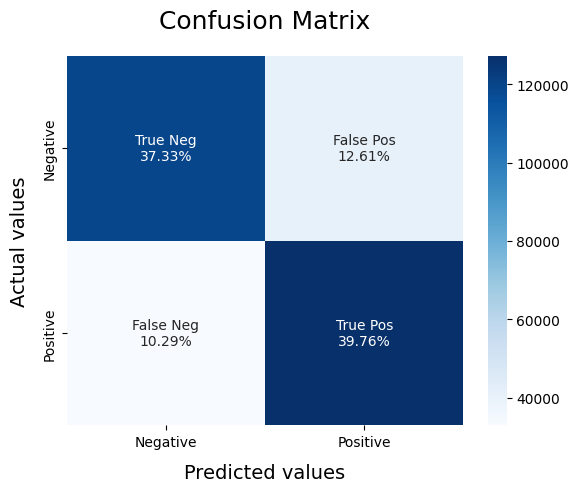

In [42]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

## **Saving the** **Models**

In [43]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

## **Prediction**

In [44]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''

    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()

    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)

    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))

    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()

    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]

    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                              text sentiment
0                   I hate twitter  Negative
1       May the Force be with you.         4
2  Mr. Stark, I don't feel so good         4
